# Training hybrid models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve, mean_squared_error
from sklearn.utils import resample
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, Dot
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
from itertools import product


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define funnctions

In [3]:
def preprocess_data(train_final_pd, test_final_pd, rank):
    """
    Preprocesses the training and test datasets for the hybrid model.

    Args:
    train_final_pd (DataFrame): DataFrame containing the training data.
    test_final_pd (DataFrame): DataFrame containing the test data.
    rank (int): The dimensionality of the feature vectors.

    Returns:
    Tuple: A tuple containing the preprocessed data arrays and DataFrames.

    """
    # Replace NA values with zeros in user_features and business_features columns
    train_final_pd['user_features'] = train_final_pd['user_features'].apply(lambda x: np.zeros(rank) if x is None else x)
    train_final_pd['business_features'] = train_final_pd['business_features'].apply(lambda x: np.zeros(rank) if x is None else x)
    test_final_pd['user_features'] = test_final_pd['user_features'].apply(lambda x: np.zeros(rank) if x is None else x)
    test_final_pd['business_features'] = test_final_pd['business_features'].apply(lambda x: np.zeros(rank) if x is None else x)

    # Calculate dot product of user_features and business_features
    train_final_pd['features_dot'] = train_final_pd.apply(lambda row: np.dot(row['user_features'], row['business_features']), axis=1)
    test_final_pd['features_dot'] = test_final_pd.apply(lambda row: np.dot(row['user_features'], row['business_features']), axis=1)

    # Calculate the proportion of features_dot being 0 in the test set
    test_zero_ratio = (test_final_pd['features_dot'] == 0).mean()

    # Calculate the proportion of features_dot being 0 in the train set
    train_zero_ratio = (train_final_pd['features_dot'] == 0).mean()

    # Calculate the adjustment ratio needed
    adjustment_ratio = (test_zero_ratio - train_zero_ratio) / (1 - train_zero_ratio)

    # Get the indices of non-zero features_dot
    non_zero_indices = train_final_pd[train_final_pd['features_dot'] != 0].index

    # Randomly select a portion of non-zero features_dot and set them to 0
    num_adjustments = int(len(non_zero_indices) * adjustment_ratio)
    adjust_indices = np.random.choice(non_zero_indices, size=num_adjustments, replace=False)
    train_final_pd.loc[adjust_indices, 'features_dot'] = 0

    # Calculate the ratio of feature=0 when dot=0 in the test set
    test_dot_zero = test_final_pd[test_final_pd['features_dot'] == 0]
    user_features_zero_ratio = test_dot_zero['user_features'].apply(lambda features: np.array_equal(features, np.zeros(rank))).mean()
    business_features_zero_ratio = test_dot_zero['business_features'].apply(lambda features: np.array_equal(features, np.zeros(rank))).mean()

    # Adjust user_features and business_features to 0 based on dot=0 in the test set
    user_num_adjustments = int(len(adjust_indices) * user_features_zero_ratio)
    business_num_adjustments = int(len(adjust_indices) * business_features_zero_ratio)
    user_adjust_indices = np.random.choice(adjust_indices, size=user_num_adjustments, replace=False)
    business_adjust_indices = np.random.choice(adjust_indices, size=business_num_adjustments, replace=False)
    train_final_pd.loc[user_adjust_indices, 'user_features'] = train_final_pd.loc[user_adjust_indices, 'user_features'].apply(lambda x: np.zeros(rank))
    train_final_pd.loc[business_adjust_indices, 'business_features'] = train_final_pd.loc[business_adjust_indices, 'business_features'].apply(lambda x: np.zeros(rank))

    # Oversample the minority class to balance the dataset
    majority = train_final_pd[train_final_pd['rating_binary'] == 1]  # Majority class
    minority = train_final_pd[train_final_pd['rating_binary'] == 0]  # Minority class
    minority_oversampled = resample(minority, replace=True, n_samples=len(majority), random_state=123)
    oversampled_train = pd.concat([majority, minority_oversampled])
    oversampled_train = oversampled_train.sample(frac=1, random_state=42).reset_index(drop=True)

    # Add indicator columns for dot=0, user_features=0, and business_features=0
    oversampled_train['dot_is_zero'] = (oversampled_train['features_dot'] == 0).astype(int)
    test_final_pd['dot_is_zero'] = (test_final_pd['features_dot'] == 0).astype(int)
    oversampled_train['user_is_zero'] = oversampled_train['user_features'].apply(lambda features: int(np.array_equal(features, np.zeros(rank))))
    test_final_pd['user_is_zero'] = test_final_pd['user_features'].apply(lambda features: int(np.array_equal(features, np.zeros(rank))))
    oversampled_train['business_is_zero'] = oversampled_train['business_features'].apply(lambda features: int(np.array_equal(features, np.zeros(rank))))
    test_final_pd['business_is_zero'] = test_final_pd['business_features'].apply(lambda features: int(np.array_equal(features, np.zeros(rank))))

    # Converting features to NumPy arrays for training inputs
    oversampled_train_user_features = np.array([x for x in oversampled_train['user_features']])
    oversampled_train_business_features = np.array([x for x in oversampled_train['business_features']])
    oversampled_train_ratings = oversampled_train['rating_binary'].values
    test_user_features = np.array([x for x in test_final_pd['user_features']])
    test_business_features = np.array([x for x in test_final_pd['business_features']])
    test_ratings = test_final_pd['rating_binary'].values

    return oversampled_train_user_features, oversampled_train_business_features, oversampled_train_ratings, test_user_features, test_business_features, test_ratings, oversampled_train, test_final_pd


In [4]:
def check_train_test_proportions(oversampled_train, test_final_pd, oversampled_train_user_features, test_user_features, oversampled_train_business_features, test_business_features, rank):
    """
    Check the proportions of the training and test sets

    Parameters:
    - oversampled_train: DataFrame of the oversampled training set
    - test_final: DataFrame of the test set
    - oversampled_train_user_features: User features of the oversampled training set
    - test_user_features: User features of the test set
    - oversampled_train_business_features: Business features of the oversampled training set
    - test_business_features: Business features of the test set
    - rank: Dimension of user and business features

    Returns:
    - None
    """

    # Calculate the ratio of features_dot being 0 in the oversampled training set
    oversampled_train_zero_dot_ratio = (oversampled_train['features_dot'] == 0).mean()
    print(f"Training set 'features_dot' == 0 ratio: {oversampled_train_zero_dot_ratio:.2%}")

    # Calculate the ratio of features_dot being 0 in the test set
    test_zero_dot_ratio = (test_final_pd['features_dot'] == 0).mean()
    print(f"Test set 'features_dot' == 0 ratio: {test_zero_dot_ratio:.2%}")

    # Calculate the ratio of user_features being 0 when features_dot is 0 in the oversampled training set
    dot_zero_data = oversampled_train[oversampled_train['features_dot'] == 0]
    user_features_zero_ratio = dot_zero_data['user_features'].apply(lambda features: np.array_equal(features, np.zeros(rank))).mean()
    print("Training set 'user_features' == 0 when 'features_dot' == 0 ratio:", user_features_zero_ratio)

    # Calculate the ratio of business_features being 0 when features_dot is 0 in the oversampled training set
    business_features_zero_ratio = dot_zero_data['business_features'].apply(lambda features: np.array_equal(features, np.zeros(rank))).mean()
    print("Training set 'business_features' == 0 when 'features_dot' == 0 ratio:", business_features_zero_ratio)

    # Calculate the ratio of user_features being 0 when features_dot is 0 in the test set
    dot_zero_data = test_final_pd[test_final_pd['features_dot'] == 0]
    user_features_zero_ratio = dot_zero_data['user_features'].apply(lambda features: np.array_equal(features, np.zeros(rank))).mean()
    print("Test set 'user_features' == 0 when 'features_dot' == 0 ratio:", user_features_zero_ratio)

    # Calculate the ratio of business_features being 0 when features_dot is 0 in the test set
    business_features_zero_ratio = dot_zero_data['business_features'].apply(lambda features: np.array_equal(features, np.zeros(rank))).mean()
    print("Test set 'business_features' == 0 when 'features_dot' == 0 ratio:", business_features_zero_ratio)

    # Calculate the ratio of all-zero vectors in user_features in the oversampled training set
    zero_vector_ratio_train_user = np.mean(np.all(oversampled_train_user_features == 0, axis=1))
    print(f"Training set 'user_features' all-zero vector ratio: {zero_vector_ratio_train_user:.2%}")

    # Calculate the ratio of all-zero vectors in user_features in the test set
    zero_vector_ratio_test_user = np.mean(np.all(test_user_features == 0, axis=1))
    print(f"Test set 'user_features' all-zero vector ratio: {zero_vector_ratio_test_user:.2%}")

    # Calculate the ratio of all-zero vectors in business_features in the oversampled training set
    zero_vector_ratio_train_business = np.mean(np.all(oversampled_train_business_features == 0, axis=1))
    print(f"Training set 'business_features' all-zero vector ratio: {zero_vector_ratio_train_business:.2%}")

    # Calculate the ratio of all-zero vectors in business_features in the test set
    zero_vector_ratio_test_business = np.mean(np.all(test_business_features == 0, axis=1))
    print(f"Test set 'business_features' all-zero vector ratio: {zero_vector_ratio_test_business:.2%}")


In [5]:
def build_model(train_data, rank):
    """
    Builds and compiles the hybrid model.

    Args:
    train_data (DataFrame): DataFrame containing the training data.
    rank (int): The dimensionality of the feature vectors.

    Returns:
    Model: Compiled Keras model for collaborative filtering.

    """
    # Extract maximum user and business IDs
    max_user_id = int(train_data['user_id'].max()) + 1
    max_business_id = int(train_data['business_id'].max()) + 1

    # Define input layers for user and business features, IDs, dot product, average rating, number of reviews, and zero indicators
    user_features = Input(shape=(rank,), name='user_features')
    business_features = Input(shape=(rank,), name='business_features')
    user_id_input = Input(shape=(1,), name='user_id')
    business_id_input = Input(shape=(1,), name='business_id')
    features_dot = Input(shape=(1,), name='features_dot')
    avg_rating = Input(shape=(1,), name='avg_rating')
    num_of_reviews = Input(shape=(1,), name='num_of_reviews')
    dot_zero_input = Input(shape=(1,), name='dot_zero_input')
    user_zero_input = Input(shape=(1,), name='user_zero_input')
    business_zero_input = Input(shape=(1,), name='business_zero_input')

    # Embed user and business IDs
    user_embedding = Embedding(output_dim=32, input_dim=max_user_id, input_length=1, name='user_embedding')(user_id_input)
    business_embedding = Embedding(output_dim=32, input_dim=max_business_id, input_length=1, name='business_embedding')(business_id_input)
    user_vec = Flatten(name='FlattenUsers')(user_embedding)
    business_vec = Flatten(name='FlattenItems')(business_embedding)

    # Add dense layers for user and business features
    user_fc = Dense(32, activation='relu')(user_features)
    business_fc = Dense(32, activation='relu')(business_features)

    # Concatenate all input features
    concatenated = Concatenate()([user_fc, business_fc, user_vec, business_vec, features_dot, avg_rating, num_of_reviews, dot_zero_input, user_zero_input, business_zero_input])

    # Define dense layers for the neural network
    x = Dense(128, activation='relu')(concatenated)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Compile the model
    model = Model(inputs=[user_features, business_features, user_id_input, business_id_input, features_dot, avg_rating, num_of_reviews, dot_zero_input, user_zero_input, business_zero_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

    return model


## Hawaii Data

### 10%

In [6]:
# Load training and testing DataFrames from parquet files
train_final_pd_10 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final//train_final_10.parquet")
test_final_pd_10 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final//test_final_10.parquet")

# Data Preprocessing:
oversampled_train_user_features_10, oversampled_train_business_features_10, oversampled_train_ratings_10, test_user_features_10, test_business_features_10, test_ratings_10, oversampled_train_10, test_final_pd_10 = preprocess_data(train_final_pd_10, test_final_pd_10, 60)


In [7]:
# Check proportions
check_train_test_proportions(oversampled_train_10, test_final_pd_10, oversampled_train_user_features_10, test_user_features_10, oversampled_train_business_features_10, test_business_features_10, 60)

Training set 'features_dot' == 0 ratio: 78.31%
Test set 'features_dot' == 0 ratio: 73.97%
Training set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9861401763353803
Training set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.04597927887749151
Test set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9851931330472103
Test set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.04570815450643777
Training set 'user_features' all-zero vector ratio: 77.23%
Test set 'user_features' all-zero vector ratio: 72.87%
Training set 'business_features' all-zero vector ratio: 3.60%
Test set 'business_features' all-zero vector ratio: 3.38%


In [8]:
oversampled_train_10

,business,user,rating,avg_rating,num_of_reviews,rating_binary,business_id,user_id,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7c006e0f175579c7:0x864109ae9a7089d1,105723365078569148731,2.0,3.6,74,0,4008.0,40308.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.13170016, -0.11164329, 0.092849225, -0.0163...",0.000000,1,1,0
1,0x795230e4d5e2f75b:0xca12bac08861fb5c,108520905878389020190,5.0,4.5,1213,1,61.0,4525.0,"[-0.037146732, -0.059287783, -0.030827258, 0.1...","[-0.07713754, -0.013998009, -0.113512516, 0.09...",0.814857,0,0,0
2,0x79540f1cc510652b:0xd702a9146f18dc1e,106352108153071241708,5.0,3.4,16,1,7342.0,9588.0,"[-0.051932923, -0.014688447, -0.05541443, 0.19...","[-0.057286955, -0.016202755, -0.06112739, 0.21...",0.909346,0,0,0
3,0x7c0072761fe019ad:0xee85c5aed8448988,111278645821888708708,4.0,4.5,6669,0,4.0,64066.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.045682274, 0.041203663, 0.060487773, 0.0852...",0.000000,1,1,0
4,0x7c00137b09f72541:0xe1231e1dc11ba124,114021892617861839687,4.0,4.2,198,0,1216.0,5410.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.012343487, 0.024139097, -0.02527718, 0.041...",0.000000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148881,0x7954d2c0a21b1ed3:0xa58773d7e5646243,117682472834418862506,4.0,4.6,3905,0,13.0,90815.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.008874344, 0.09552872, 0.23378305, 0.18417...",0.000000,1,1,0
148882,0x79552b46b0979587:0x8973433044407fc1,103326836725705135186,1.0,4.2,84,0,4814.0,30235.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,1,1,1
148883,0x79524b598954ba4b:0x82b950b4611f58b8,117483042470331395471,4.0,4.2,78,0,3759.0,90000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.075762354, 0.032841593, 0.11952602, 0.0163...",0.000000,1,1,0
148884,0x7c006e78b6d1e877:0xaef768563123ad04,117969612626675309337,4.0,4.3,218,0,1962.0,6046.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.043209553, -0.05817612, -0.103643976, -0.02...",0.000000,1,1,0


In [9]:
test_final_pd_10

,business,user,rating,avg_rating,num_of_reviews,rating_binary,business_id,user_id,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7c00670ed6629fcb:0x296d3c57c346f2a7,104432966890301301955,5.0,4.1,648,1,305.0,533.0,"[0.0030209192, 0.15469228, -0.06496346, 0.0344...","[0.08490408, 0.063143976, -0.12838304, -0.0513...",0.520984,0,0,0
1,0x7c00670ed6629fcb:0x296d3c57c346f2a7,106024223755114141206,2.0,4.1,648,0,305.0,559.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08490408, 0.063143976, -0.12838304, -0.0513...",0.000000,1,1,0
2,0x7c006ad8d25c7541:0xd3f5022d145a7263,106289453535247260640,5.0,4.4,71,1,2734.0,1275.0,"[-0.20133606, -0.14030628, 0.039926086, 0.0446...","[0.017421737, -0.016460948, -0.042707562, -0.1...",0.119287,0,0,0
3,0x7c006ddaffffffff:0xdca9e2cf60ebd2f6,110783458692269250173,4.0,4.1,424,0,496.0,1450.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.009422253, 0.106154725, -0.17899916, -0.01...",0.000000,1,1,0
4,0x7c008a3148952c4b:0x1edce29ce3d2c1c,100884087427142495971,5.0,3.8,148,1,2815.0,1742.0,"[-0.040712535, 0.056900352, -0.07359079, -0.02...","[-0.19265673, -0.04059872, -0.19485062, 0.2028...",0.290295,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,0x79540efea4a86201:0xf8188a94d1d3deb,115595341943509003282,4.0,4.3,886,0,110.0,82232.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.08934926, -0.17168546, -0.1094383, 0.00051...",0.000000,1,1,0
12596,0x7c008bb4b45cfb75:0x7780afb982386a6b,115920995926567778684,5.0,4.5,554,1,487.0,83575.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.045685682, -0.041698404, -0.03365104, 0.04...",0.000000,1,1,0
12597,0x79552b49a0ede727:0xdc80148e6c88bb42,117458602894833479098,2.0,4.0,216,0,2016.0,89887.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.20923649, -0.0029354852, 0.12305564, -0.07...",0.000000,1,1,0
12598,0x7c00633d66c724d1:0xafe7218622605fc8,117511200685703706031,5.0,4.4,378,1,446.0,90120.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.20669235, 0.046117112, 0.03175042, -0.11882...",0.000000,1,1,0


In [ ]:
# Build model
model = build_model(train_final_pd_10,60)

# Train the Model: Trains the neural network model using oversampled training data and evaluates on validation set.
model.fit([oversampled_train_user_features_10, oversampled_train_business_features_10, oversampled_train_10['user_id'], oversampled_train_10['business_id'],
      oversampled_train_10['features_dot'], oversampled_train_10['avg_rating'], oversampled_train_10['num_of_reviews'], oversampled_train_10['dot_is_zero'],
      oversampled_train_10['user_is_zero'], oversampled_train_10['business_is_zero']], oversampled_train_10['rating_binary'], batch_size=32, epochs=10, validation_split=0.1)

# Evaluate the Model on the Test Set: Evaluates the trained model on the test set and prints the metrics.
test_metrics = model.evaluate([test_user_features_10, test_business_features_10, test_final_pd_10['user_id'], test_final_pd_10['business_id'],
                test_final_pd_10['features_dot'], test_final_pd_10['avg_rating'], test_final_pd_10['num_of_reviews'],
                test_final_pd_10['dot_is_zero'], test_final_pd_10['user_is_zero'], test_final_pd_10['business_is_zero']],
                test_final_pd_10['rating_binary'])

# Saves to an HDF5 file
model.save('/content/model_10.h5')

print("Test Metrics:")
print(f"Accuracy: {test_metrics[1]}")
print(f"Precision: {test_metrics[2]}")
print(f"Recall: {test_metrics[3]}")


Epoch 1/10
4188/4188 [==============================] - 51s 11ms/step - loss: 9.5138 - accuracy: 0.5047 - precision: 0.5047 - recall: 0.5060 - val_loss: 0.6946 - val_accuracy: 0.4993 - val_precision: 0.4993 - val_recall: 1.0000
Epoch 2/10
4188/4188 [==============================] - 47s 11ms/step - loss: 1.1143 - accuracy: 0.5036 - precision: 0.5022 - recall: 0.8581 - val_loss: 0.6934 - val_accuracy: 0.4993 - val_precision: 0.4993 - val_recall: 1.0000
Epoch 3/10
4188/4188 [==============================] - 42s 10ms/step - loss: 0.7286 - accuracy: 0.4986 - precision: 0.4993 - recall: 0.9691 - val_loss: 0.6932 - val_accuracy: 0.4993 - val_precision: 0.4993 - val_recall: 1.0000
Epoch 4/10
4188/4188 [==============================] - 45s 11ms/step - loss: 0.7004 - accuracy: 0.4993 - precision: 0.4996 - recall: 0.9065 - val_loss: 0.6920 - val_accuracy: 0.5106 - val_precision: 0.5781 - val_recall: 0.0732
Epoch 5/10
4188/4188 [==============================] - 41s 10ms/step - loss: 0.6941 - a

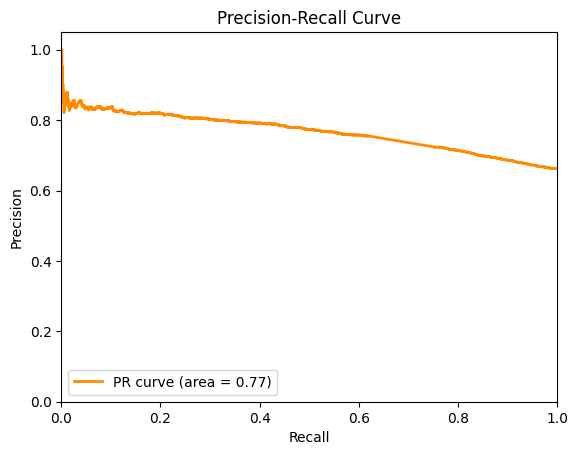

In [ ]:

# Predict ratings using the trained model on the test set
y_pred = model.predict([test_user_features_10, test_business_features_10, test_final_pd_10['user_id'], test_final_pd_10['business_id'],
                        test_final_pd_10['features_dot'], test_final_pd_10['avg_rating'], test_final_pd_10['num_of_reviews'],
                        test_final_pd_10['dot_is_zero'], test_final_pd_10['user_is_zero'], test_final_pd_10['business_is_zero']])

# Get the true ratings from the test set
y_true = test_final_pd_10['rating_binary']

# Calculate Precision, Recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Calculate AUC
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


### 20%

In [11]:
# Load training and testing DataFrames from parquet files
train_final_pd_20 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final/train_final_20.parquet")
test_final_pd_20 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final/test_final_20.parquet")

# Data Preprocessing:
oversampled_train_user_features_20, oversampled_train_business_features_20, oversampled_train_ratings_20, test_user_features_20, test_business_features_20, test_ratings_20, oversampled_train_20, test_final_pd_20 = preprocess_data(train_final_pd_20, test_final_pd_20, 60)


In [12]:
# Check proportions
check_train_test_proportions(oversampled_train_20, test_final_pd_20, oversampled_train_user_features_20, test_user_features_20, oversampled_train_business_features_20, test_business_features_20, 60)


Training set 'features_dot' == 0 ratio: 67.84%
Test set 'features_dot' == 0 ratio: 62.97%
Training set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9908658486143664
Training set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.02202044474207717
Test set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9906007875015878
Test set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.021275244506541342
Training set 'user_features' all-zero vector ratio: 67.22%
Test set 'user_features' all-zero vector ratio: 62.38%
Training set 'business_features' all-zero vector ratio: 1.49%
Test set 'business_features' all-zero vector ratio: 1.34%


In [13]:
oversampled_train_20

,business,user,rating,avg_rating,num_of_reviews,user_id,business_id,rating_binary,__index_level_0__,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7c006dfb694db30f:0xb008a4e90f5b7556,118423732592866317925,4.0,4.5,296,163864,8075,0,151560,"[-0.05802784, 0.11843262, 0.08459775, 0.116590...","[-0.1165373, 0.16485581, 0.11637486, 0.0816805...",0.173944,0,0,0
1,0x795401cbec5a1bf1:0xa4d18fb4fa42e294,105930400888236090907,5.0,4.7,3526,52860,1273,1,2548,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.17122248, 0.12269002, 0.20608343, 0.080093...",0.000000,1,1,0
2,0x7c006dfb62829bb5:0xd2bfef82e04a5bea,106660843382459028523,4.0,4.8,563,59327,8073,0,151448,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.030839493, 0.017372813, 0.10003478, 0.0565...",0.000000,1,1,0
3,0x7c006df35c08582b:0xd8c4d80a715e5c95,105373341814160486633,5.0,4.2,324,47848,7952,1,148555,"[-0.11169305, 0.045570184, 0.18044204, -0.0576...","[-0.082221024, 0.03354575, 0.13282947, -0.0424...",0.864155,0,0,0
4,0x7c006de20677073d:0xbdd716a3467c8b66,112581833764502303873,5.0,4.5,24,112181,7273,1,135278,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.09887482, -0.024091663, 0.075399026, 0.177...",0.000000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299343,0x7c006f55639bb2c3:0xaa15cc24453b8e47,110329232333481383702,5.0,4.4,952,92076,9475,1,176774,"[-0.016760904, 0.10516544, 0.27555975, -0.0282...","[-0.014995302, 0.09408725, 0.24653214, -0.0252...",0.888226,0,0,0
299344,0x7954d2c03322b8db:0x6da50f5cd964437d,113940188662575692187,4.0,4.1,293,124414,2536,0,45386,"[-0.123421766, 0.0729122, -0.059725672, 0.1622...","[-0.20416665, -0.08524451, 0.13593687, -0.0946...",0.074846,0,0,0
299345,0x7c07045503e912f3:0x9c5733ee9290cdc5,117034625388797294589,5.0,4.6,188,151680,10800,1,207938,"[0.05596262, 0.025777884, 0.29251906, 0.066680...","[0.05230994, 0.024095362, 0.27342635, 0.062328...",0.893017,0,0,0
299346,0x7954daa112667b55:0xf63a6e969a151f46,104375611512502964052,5.0,4.4,67,38995,3146,1,55601,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021921167, -0.07616935, 0.15683062, 0.14120...",0.000000,1,1,0


In [14]:
test_final_pd_20

,business,user,rating,avg_rating,num_of_reviews,user_id,business_id,rating_binary,__index_level_0__,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7c006dfb694db30f:0xb008a4e90f5b7556,100925352148114292322,3.0,4.5,296,8199,8075,0,151517,"[-0.04113594, 0.061239135, 0.35559714, -0.0276...","[-0.1165373, 0.16485581, 0.11637486, 0.0816805...",0.361211,0,0,0
1,0x795380c5109d63e5:0xddf857c061c67aee,102161823004652254870,5.0,4.6,698,19155,964,1,1733,"[0.22451401, 0.08114818, 0.047792714, -0.02163...","[-0.036207087, 0.05800278, 0.22725467, -0.1081...",0.389660,0,0,0
2,0x7c071ac82ad4c897:0x5d1e6423a06f5dc8,102343803653579233160,5.0,4.2,685,20794,10959,1,211943,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.12902197, 0.04536385, 0.0040596705, 0.1003...",0.000000,1,1,0
3,0x795380c5109d63e5:0xddf857c061c67aee,102925777543955195031,5.0,4.6,698,25874,964,1,1734,"[-0.12110502, 0.17701763, 0.11117093, 0.083933...","[-0.036207087, 0.05800278, 0.22725467, -0.1081...",0.467261,0,0,0
4,0x7c071ac82ad4c897:0x5d1e6423a06f5dc8,103507314609127970011,3.0,4.2,685,31178,10959,0,211954,"[-0.24059445, 0.30123726, 0.065711506, -0.1084...","[-0.12902197, 0.04536385, 0.0040596705, 0.1003...",0.299110,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25001,0x7c06e05a95aecf6b:0xa0507a89e000217f,117866316920199898352,5.0,4.7,185,159017,10519,1,203473,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.12063263, -0.00705439, -0.032425165, 0.099...",0.000000,1,1,0
25002,0x7954819dd390e61b:0x7a9d469156f9a1c4,117922470307925487541,5.0,4.6,218,159542,2015,1,36039,"[0.031675853, 0.09141651, 0.045309354, 0.19774...","[-0.045340553, 0.0114676505, 0.08191628, 0.014...",0.466513,0,0,0
25003,0x7954d36bcda84d91:0xaa2594f24e06f692,118141687657614499485,5.0,3.7,438,161407,3045,1,54590,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0965507, -0.006472157, 0.013004723, 0.0592...",0.000000,1,1,0
25004,0x7c006df43e75d2cd:0x669df3ef993988bc,118144834326711637459,5.0,3.7,624,161434,7977,1,149309,"[-0.071315564, 0.18992327, 0.010272553, 0.1305...","[-0.15693977, 0.022714138, 0.12422771, 0.03489...",0.221537,0,0,0


In [ ]:
# Build model
model = build_model(train_final_pd_20, 60)

# Train the Model: Trains the neural network model using oversampled training data and evaluates on validation set.
model.fit([oversampled_train_user_features_20, oversampled_train_business_features_20, oversampled_train_20['user_id'], oversampled_train_20['business_id'],
      oversampled_train_20['features_dot'], oversampled_train_20['avg_rating'], oversampled_train_20['num_of_reviews'], oversampled_train_20['dot_is_zero'],
      oversampled_train_20['user_is_zero'], oversampled_train_20['business_is_zero']], oversampled_train_20['rating_binary'], batch_size=32, epochs=10, validation_split=0.1)

# Evaluate the Model on the Test Set: Evaluates the trained model on the test set and prints the metrics.
test_metrics = model.evaluate([test_user_features_20, test_business_features_20, test_final_pd_20['user_id'], test_final_pd_20['business_id'],
                test_final_pd_20['features_dot'], test_final_pd_20['avg_rating'], test_final_pd_20['num_of_reviews'],
                test_final_pd_20['dot_is_zero'], test_final_pd_20['user_is_zero'], test_final_pd_20['business_is_zero']],
                test_final_pd_20['rating_binary'])

# Saves to an HDF5 file
model.save('/content/model_20.h5')

print("Test Metrics:")
print(f"Accuracy: {test_metrics[1]}")
print(f"Precision: {test_metrics[2]}")
print(f"Recall: {test_metrics[3]}")


Epoch 1/10
8420/8420 [==============================] - 94s 11ms/step - loss: 6.0294 - accuracy: 0.5034 - precision_1: 0.5039 - recall_1: 0.4163 - val_loss: 0.6905 - val_accuracy: 0.5199 - val_precision_1: 0.7121 - val_recall_1: 0.0714
Epoch 2/10
8420/8420 [==============================] - 97s 12ms/step - loss: 0.7327 - accuracy: 0.5347 - precision_1: 0.5923 - recall_1: 0.2219 - val_loss: 0.6706 - val_accuracy: 0.5693 - val_precision_1: 0.7627 - val_recall_1: 0.2047
Epoch 3/10
8420/8420 [==============================] - 74s 9ms/step - loss: 0.6267 - accuracy: 0.6248 - precision_1: 0.7942 - recall_1: 0.3365 - val_loss: 0.5384 - val_accuracy: 0.6982 - val_precision_1: 0.9936 - val_recall_1: 0.4007
Epoch 4/10
8420/8420 [==============================] - 69s 8ms/step - loss: 0.5145 - accuracy: 0.7287 - precision_1: 0.9187 - recall_1: 0.5015 - val_loss: 0.4703 - val_accuracy: 0.7634 - val_precision_1: 0.9540 - val_recall_1: 0.5548
Epoch 5/10
8420/8420 [==============================] - 67

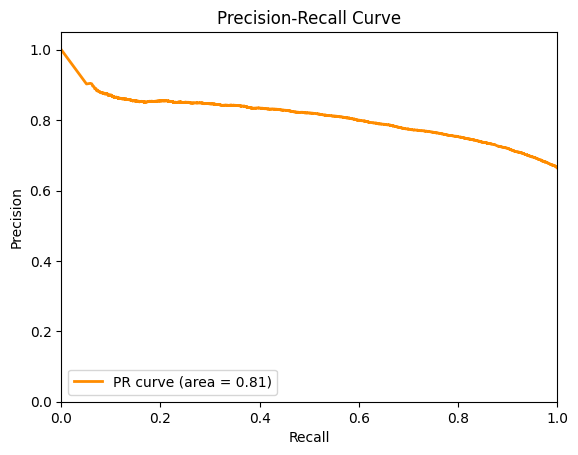

In [ ]:
# Predict ratings using the trained model on the test set
y_pred = model.predict([test_user_features_20, test_business_features_20, test_final_pd_20['user_id'], test_final_pd_20['business_id'],
                        test_final_pd_20['features_dot'], test_final_pd_20['avg_rating'], test_final_pd_20['num_of_reviews'],
                        test_final_pd_20['dot_is_zero'], test_final_pd_20['user_is_zero'], test_final_pd_20['business_is_zero']])

# Get the true ratings from the test set
y_true = test_final_pd_20['rating_binary']

# Calculate Precision, Recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Calculate AUC
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()



### 50%

In [16]:
# Load training and testing DataFrames from parquet files
train_final_pd_50 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final//train_final_50.parquet")
test_final_pd_50 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final//test_final_50.parquet")

# Data Preprocessing:
oversampled_train_user_features_50, oversampled_train_business_features_50, oversampled_train_ratings_50, test_user_features_50, test_business_features_50, test_ratings_50, oversampled_train_50, test_final_pd_50 = preprocess_data(train_final_pd_50, test_final_pd_50, 60)


In [17]:
# Check proportions
check_train_test_proportions(oversampled_train_50, test_final_pd_50, oversampled_train_user_features_50, test_user_features_50, oversampled_train_business_features_50, test_business_features_50, 60)



Training set 'features_dot' == 0 ratio: 51.81%
Test set 'features_dot' == 0 ratio: 46.95%
Training set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9957492194021084
Training set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.007174802403107965
Test set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9955667712453963
Test set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.00692265720911199
Training set 'user_features' all-zero vector ratio: 51.58%
Test set 'user_features' all-zero vector ratio: 46.74%
Training set 'business_features' all-zero vector ratio: 0.37%
Test set 'business_features' all-zero vector ratio: 0.33%


In [18]:
oversampled_train_50

,business,user,rating,avg_rating,num_of_reviews,user_id,business_id,rating_binary,__index_level_0__,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7954dac522ea4ba9:0xffcb07b041d3f98e,106497840366616748804,3.0,4.2,98,113685,3431,0,141118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.17865416, 0.29892698, -0.20565678, 0.06874...",0.000000,1,1,0
1,0x79537d0b3bd0450f:0x64d4d42f57f00e4b,110633085517136038358,5.0,4.3,388,186302,1020,1,38458,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2640347, 0.06401174, 0.044780467, -0.00312...",0.000000,1,1,0
2,0x79540f118197055f:0xe57b905a4fce5034,102366933086568197430,5.0,4.7,28,41169,1953,1,83444,"[-0.18473269, 0.18233058, 0.033887777, 0.18997...","[-0.17513019, 0.17285293, 0.032126274, 0.18010...",0.894517,0,0,0
3,0x7c06e0f15e32fc91:0x8ceaa37b46c62390,101210460163849807513,2.0,4.1,218,20929,11352,0,510150,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00927732, 0.03188844, -0.15453237, 0.11750...",0.000000,1,1,0
4,0x79540efbfe143ed3:0x1b820597d8636ac0,105920049631818992881,5.0,4.3,393,103578,1868,1,77756,"[-0.15160093, 0.08805208, -0.022693124, 0.0267...","[-0.13988979, 0.08125008, -0.020940086, 0.0246...",0.891628,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749273,0x7c006df285684f4d:0x743cbc16e6ee4720,109214274377146015100,5.0,4.0,108,161388,8488,1,369686,"[0.040957835, 0.28664163, -0.08503877, 0.13648...","[-0.023160048, 0.15431054, -0.1014621, 0.02228...",0.846788,0,0,0
749274,0x7c00660d9969ef49:0x2209f70990813902,115071199124532938504,5.0,4.0,568,263983,5995,1,269338,"[0.061473668, 0.10152695, -0.042469468, 0.0277...","[0.19546393, 0.022997905, 0.013649088, 0.03047...",0.735242,0,0,0
749275,0x7c06e0f16123525f:0x726d9354a4680654,108016042646817206575,5.0,3.8,518,140127,11353,1,510333,"[-0.17959431, 0.14487149, -0.08748697, 0.16745...","[-0.13086341, 0.10556224, -0.06374836, 0.12201...",0.862762,0,0,0
749276,0x7c006df28f7603d3:0x3e8bcdc4fdf9481,104272498765234924626,3.0,4.5,117,74817,8493,0,369872,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.010215986, 0.21542007, 0.10653105, 0.151219...",0.000000,1,1,0


In [19]:
test_final_pd_50

,business,user,rating,avg_rating,num_of_reviews,user_id,business_id,rating_binary,__index_level_0__,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7954d0735bcf9ac7:0x3e576d3c1d5443ed,100155611801212738651,4.0,4.4,538,2711,2529,0,104318,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.13901857, 0.20505174, 0.0598837, 0.0238445...",0.000000,1,1,0
1,0x7c006e6f940f1597:0xb9e7677df6977190,100440298304008705213,5.0,4.3,4980,7566,9233,1,404732,"[-0.0013054743, 0.17637123, -0.14378503, 0.060...","[-0.08812978, 0.078508794, -0.04714993, 0.0492...",0.722685,0,0,0
2,0x7c006e6f940f1597:0xb9e7677df6977190,100593466953968142832,2.0,4.3,4980,10314,9233,0,404750,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.08812978, 0.078508794, -0.04714993, 0.0492...",0.000000,1,1,0
3,0x7c006e6f940f1597:0xb9e7677df6977190,100634727267562430188,5.0,4.3,4980,11093,9233,1,45075,"[-0.06254968, 0.19133267, -0.028907381, 0.0250...","[-0.08812978, 0.078508794, -0.04714993, 0.0492...",0.652867,0,0,0
4,0x7c006df27fb3bf7f:0x92b1fd6040c98868,100681450448857979037,1.0,4.6,664,11901,8484,0,369252,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.029346712, -0.09999946, -0.20172186, 0.183...",0.000000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62449,0x7954d2c4f2ae350b:0xbb8405b939fa4a4f,117668442386894646370,5.0,4.9,246,309414,2833,1,120143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.14319919, 0.20420983, -0.09537728, 0.27132...",0.000000,1,1,0
62450,0x7954d2c4f2ae350b:0xbb8405b939fa4a4f,117851845806632129844,4.0,4.9,246,312558,2833,0,120146,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.14319919, 0.20420983, -0.09537728, 0.27132...",0.000000,1,1,0
62451,0x7954d074b3155fdd:0x9200c39ca180f0ad,117957090870251658908,5.0,4.8,132,314424,2545,1,105467,"[0.0165748, 0.14037801, -0.12423309, 0.0353854...","[0.14932017, 0.27617675, -0.126673, 0.09101215...",0.460250,0,0,0
62452,0x7c06e04bfdf4bcc5:0x9062b5c40528ffba,118193042100013253925,4.0,4.4,2008,318538,11277,0,506517,"[-0.1530224, 0.1387667, 0.110696234, 0.180497,...","[-0.1494733, 0.040951677, -0.03662985, 0.07648...",0.589580,0,0,0


In [ ]:
# Build model
model = build_model(train_final_pd_50, 60)

# Train the Model: Trains the neural network model using oversampled training data and evaluates on validation set.
model.fit([oversampled_train_user_features_50, oversampled_train_business_features_50, oversampled_train_50['user_id'], oversampled_train_50['business_id'],
      oversampled_train_50['features_dot'], oversampled_train_50['avg_rating'], oversampled_train_50['num_of_reviews'], oversampled_train_50['dot_is_zero'],
      oversampled_train_50['user_is_zero'], oversampled_train_50['business_is_zero']], oversampled_train_50['rating_binary'], batch_size=32, epochs=10, validation_split=0.1)

# Evaluate the Model on the Test Set: Evaluates the trained model on the test set and prints the metrics.
test_metrics = model.evaluate([test_user_features_50, test_business_features_50, test_final_pd_50['user_id'], test_final_pd_50['business_id'],
                test_final_pd_50['features_dot'], test_final_pd_50['avg_rating'], test_final_pd_50['num_of_reviews'],
                test_final_pd_50['dot_is_zero'], test_final_pd_50['user_is_zero'], test_final_pd_50['business_is_zero']],
                test_final_pd_50['rating_binary'])

# Saves to an HDF5 file
model.save('/content/model_50.h5')

print("Test Metrics:")
print(f"Accuracy: {test_metrics[1]}")
print(f"Precision: {test_metrics[2]}")
print(f"Recall: {test_metrics[3]}")


Epoch 1/10
21074/21074 [==============================] - 212s 10ms/step - loss: 2.4660 - accuracy: 0.5382 - precision: 0.5464 - recall: 0.4495 - val_loss: 0.6383 - val_accuracy: 0.6394 - val_precision: 0.8314 - val_recall: 0.3500
Epoch 2/10
21074/21074 [==============================] - 190s 9ms/step - loss: 0.4940 - accuracy: 0.7513 - precision: 0.9168 - recall: 0.5528 - val_loss: 0.4065 - val_accuracy: 0.8001 - val_precision: 0.9936 - val_recall: 0.6043
Epoch 3/10
21074/21074 [==============================] - 186s 9ms/step - loss: 0.3749 - accuracy: 0.8233 - precision: 0.9165 - recall: 0.7114 - val_loss: 0.3065 - val_accuracy: 0.8515 - val_precision: 0.9502 - val_recall: 0.7420
Epoch 4/10
21074/21074 [==============================] - 196s 9ms/step - loss: 0.2853 - accuracy: 0.8801 - precision: 0.9275 - recall: 0.8245 - val_loss: 0.2660 - val_accuracy: 0.8853 - val_precision: 0.9263 - val_recall: 0.8373
Epoch 5/10
21074/21074 [==============================] - 188s 9ms/step - loss:

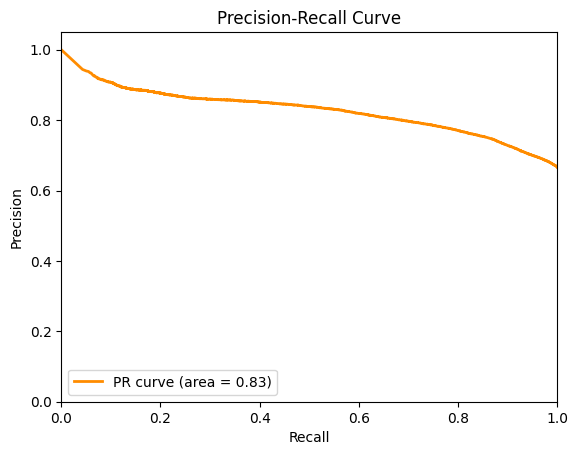

In [ ]:
# Predict ratings using the trained model on the test set
y_pred = model.predict([test_user_features_50, test_business_features_50, test_final_pd_50['user_id'], test_final_pd_50['business_id'],
                        test_final_pd_50['features_dot'], test_final_pd_50['avg_rating'], test_final_pd_50['num_of_reviews'],
                        test_final_pd_50['dot_is_zero'], test_final_pd_50['user_is_zero'], test_final_pd_50['business_is_zero']])

# Get the true ratings from the test set
y_true = test_final_pd_50['rating_binary']

# Calculate Precision, Recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Calculate AUC
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### 80%

In [21]:
# Load training and testing DataFrames from parquet files
train_final_pd_80 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final//train_final_80.parquet")
test_final_pd_80 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final//test_final_80.parquet")

# Data Preprocessing:
oversampled_train_user_features_80, oversampled_train_business_features_80, oversampled_train_ratings_80, test_user_features_80, test_business_features_80, test_ratings_80, oversampled_train_80, test_final_pd_80 = preprocess_data(train_final_pd_80, test_final_pd_80, 60)


In [22]:
# Check proportions
check_train_test_proportions(oversampled_train_80, test_final_pd_80, oversampled_train_user_features_80, test_user_features_80, oversampled_train_business_features_80, test_business_features_80, 60)


Training set 'features_dot' == 0 ratio: 43.75%
Test set 'features_dot' == 0 ratio: 39.27%
Training set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9980931345199973
Training set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.0029997783603249698
Test set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9981883133452412
Test set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.0026282214850727225
Training set 'user_features' all-zero vector ratio: 43.67%
Test set 'user_features' all-zero vector ratio: 39.20%
Training set 'business_features' all-zero vector ratio: 0.13%
Test set 'business_features' all-zero vector ratio: 0.10%


In [28]:
oversampled_train_80

,business,user,rating,avg_rating,num_of_reviews,user_id,business_id,rating_binary,__index_level_0__,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7c0045110cd9a3f7:0x54c748ca268fcebc,116343302728840435112,5.0,4.8,468,395347,4630,1,312227,"[-0.020651344, -0.09083509, 0.14599508, -0.251...","[-0.006487951, -0.14401184, 0.056627296, -0.25...",0.720907,0,0,0
1,0x7c071a96a39ff3e7:0xcd52d83bd74ce95f,102613404390988592773,5.0,4.0,723,62830,11943,1,840962,"[0.09063632, 0.0277426, 0.19629866, -0.1271445...","[0.07181793, 0.021982534, 0.15554209, -0.10074...",0.873797,0,0,0
2,0x79552bb9cd5d90d9:0x2e4e22ad3dc73ed4,111066530224666239439,5.0,4.5,68,267671,3889,1,248130,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.020151142, 0.000853559, 0.1489889, -0.02460...",0.000000,1,1,0
3,0x7954d31547c72811:0x33ee28117b14c259,115959671859029205925,4.0,4.7,112,386129,3065,0,205482,"[0.016686788, -0.0026063556, 0.015138638, -0.0...","[0.2167042, -0.0034768053, 0.068622924, -0.035...",0.086376,0,0,0
4,0x7c0014e3508ac923:0xa7cab1c7b2e94d93,105101129968157432198,5.0,4.2,1368,123114,4477,1,32955,"[-0.06677649, -0.0552181, 0.06517138, -0.07064...","[-0.09193327, -0.074884206, 0.07584978, -0.048...",0.855043,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196217,0x7954d2c27aac73d9:0x9eb2f13d1886b04c,108059388160190085166,5.0,4.8,48,194440,2828,1,188274,"[0.019153768, 0.08354058, 0.08054601, -0.06044...","[0.020338258, 0.08870682, 0.085527055, -0.0641...",0.905824,0,0,0
1196218,0x7c006ded90edd0fd:0x2dd41d606248d042,100589485510845454169,5.0,4.4,52,14170,8278,1,560264,"[-0.081598625, -0.02286016, 0.01973811, -0.022...","[-0.080493584, -0.02255058, 0.019470809, -0.02...",0.898627,0,0,0
1196219,0x7c00642df202f6b7:0x1207acd7063f1e0e,109645207424794767798,5.0,4.6,648,233005,5592,1,396684,"[0.068071045, -0.12356337, -0.037417963, -0.20...","[0.10439994, -0.10539401, 0.0035576269, -0.148...",0.880838,0,0,0
1196220,0x7c0012675bf5ab2b:0x926ea17e82a76bac,104323150779962275870,2.0,4.3,118,104298,4133,0,29874,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.083864145, -0.022832962, -0.07701969, -0.0...",0.000000,1,1,0


In [29]:
test_final_pd_80

,business,user,rating,avg_rating,num_of_reviews,user_id,business_id,rating_binary,__index_level_0__,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7954c492c8704db7:0x1f0ee2a86272c541,100016537347151420000,4.0,4.6,277,385,2250,0,146580,"[-0.08010915, 0.023588564, 0.018720144, -0.031...","[0.16097753, 0.00961735, 0.11960554, -0.070700...",0.215973,0,0,0
1,0x7c006efc8282535d:0xa93df90776ab93d9,100042053181451971016,4.0,4.5,714,989,9978,0,682604,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.050069068, -0.029801205, -0.016789563, -0....",0.000000,1,1,0
2,0x795252ad31a4ab27:0x3685910c10a8eb4,100120525476213113702,2.0,4.6,588,2828,964,0,56519,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.15288803, 0.021903832, 0.069814734, -0.1648...",0.000000,1,1,0
3,0x79540f487407c517:0x28291f3dda2d78ad,100187226102180500328,5.0,4.6,118,4377,2040,1,135056,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.15346536, 0.124251954, 0.1436802, -0.112499...",0.000000,1,1,0
4,0x7c006db2b4ec8033:0x84b108ff9c5afdc6,100236517315199168602,5.0,5.0,65,5567,7747,1,532185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07403434, -0.027686805, 0.00047111022, -0....",0.000000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99790,0x7c00636c62cba009:0xcdb1c461135668d5,118257677134538302715,5.0,4.5,148,441417,5447,1,389302,"[0.0069654435, -0.1706358, 0.04734642, 0.02143...","[-0.0030006287, -0.06960656, -0.001951887, 0.0...",0.758879,0,0,0
99791,0x7c006dfcb7e04bab:0xbffc542b77eb143b,118266596719718753060,3.0,4.3,1168,441625,8826,0,609706,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07036054, -0.013625388, 0.045715436, -0.18...",0.000000,1,1,0
99792,0x7c006d9f6a3fffff:0x93e62ce20799a22d,118276754667820581163,5.0,4.6,108,441878,7673,1,528085,"[-0.1206947, 0.010518548, 0.0026751033, -0.029...","[0.006324278, -0.117635235, 0.03785541, -0.036...",0.676900,0,0,0
99793,0x7c006dfcb7e04bab:0xbffc542b77eb143b,118322262322820589674,5.0,4.3,1168,442952,8826,1,609710,"[0.039586894, -0.0108907465, -0.11188992, 0.04...","[-0.07036054, -0.013625388, 0.045715436, -0.18...",0.455007,0,0,0


In [ ]:
# Build model
model = build_model(train_final_pd_80, 60)

# Train the Model: Trains the neural network model using oversampled training data and evaluates on validation set.
model.fit([oversampled_train_user_features_80, oversampled_train_business_features_80, oversampled_train_80['user_id'], oversampled_train_80['business_id'],
      oversampled_train_80['features_dot'], oversampled_train_80['avg_rating'], oversampled_train_80['num_of_reviews'], oversampled_train_80['dot_is_zero'],
      oversampled_train_80['user_is_zero'], oversampled_train_80['business_is_zero']], oversampled_train_80['rating_binary'], batch_size=32, epochs=10, validation_split=0.1)

# Evaluate the Model on the Test Set: Evaluates the trained model on the test set and prints the metrics.
test_metrics = model.evaluate([test_user_features_80, test_business_features_80, test_final_pd_80['user_id'], test_final_pd_80['business_id'],
                test_final_pd_80['features_dot'], test_final_pd_80['avg_rating'], test_final_pd_80['num_of_reviews'],
                test_final_pd_80['dot_is_zero'], test_final_pd_80['user_is_zero'], test_final_pd_80['business_is_zero']],
                test_final_pd_80['rating_binary'])

# Saves to an HDF5 file
model.save('/content/model_80.h5')

print("Test Metrics:")
print(f"Accuracy: {test_metrics[1]}")
print(f"Precision: {test_metrics[2]}")
print(f"Recall: {test_metrics[3]}")


Epoch 1/10
33644/33644 [==============================] - 343s 10ms/step - loss: 1.8735 - accuracy: 0.6092 - precision: 0.6325 - recall: 0.5217 - val_loss: 0.4137 - val_accuracy: 0.8125 - val_precision: 0.9838 - val_recall: 0.6351
Epoch 2/10
33644/33644 [==============================] - 311s 9ms/step - loss: 0.3969 - accuracy: 0.8189 - precision: 0.9327 - recall: 0.6875 - val_loss: 0.3058 - val_accuracy: 0.8585 - val_precision: 0.9594 - val_recall: 0.7484
Epoch 3/10
33644/33644 [==============================] - 321s 10ms/step - loss: 0.3238 - accuracy: 0.8600 - precision: 0.9274 - recall: 0.7811 - val_loss: 0.2591 - val_accuracy: 0.8821 - val_precision: 0.9536 - val_recall: 0.8030
Epoch 4/10
33644/33644 [==============================] - 317s 9ms/step - loss: 0.2700 - accuracy: 0.8934 - precision: 0.9408 - recall: 0.8397 - val_loss: 0.2516 - val_accuracy: 0.8863 - val_precision: 0.9476 - val_recall: 0.8177
Epoch 5/10
33644/33644 [==============================] - 311s 9ms/step - loss

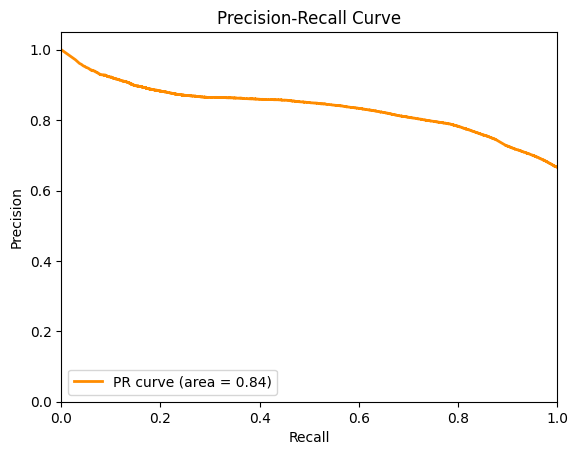

In [ ]:
# Predict ratings using the trained model on the test set
y_pred = model.predict([test_user_features_80, test_business_features_80, test_final_pd_80['user_id'], test_final_pd_80['business_id'],
                        test_final_pd_80['features_dot'], test_final_pd_80['avg_rating'], test_final_pd_80['num_of_reviews'],
                        test_final_pd_80['dot_is_zero'], test_final_pd_80['user_is_zero'], test_final_pd_80['business_is_zero']])

# Get the true ratings from the test set
y_true = test_final_pd_80['rating_binary']

# Calculate Precision, Recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Calculate AUC
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### 100%

In [23]:
# Load training and testing DataFrames from parquet files
train_final_pd_100 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final//train_final_100.parquet")
test_final_pd_100 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/hi_data/final data/final//test_final_100.parquet")

# Data Preprocessing:
oversampled_train_user_features_100, oversampled_train_business_features_100, oversampled_train_ratings_100, test_user_features_100, test_business_features_100, test_ratings_100, oversampled_train_100, test_final_pd_100 = preprocess_data(train_final_pd_100, test_final_pd_100, 60)


In [24]:
# Check proportions
check_train_test_proportions(oversampled_train_100, test_final_pd_100, oversampled_train_user_features_100, test_user_features_100, oversampled_train_business_features_100, test_business_features_100, 60)


Training set 'features_dot' == 0 ratio: 40.39%
Test set 'features_dot' == 0 ratio: 36.17%
Training set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9985669768512919
Training set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.0019764122733048495
Test set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9985380440801861
Test set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.0017720677815926459
Training set 'user_features' all-zero vector ratio: 40.33%
Test set 'user_features' all-zero vector ratio: 36.11%
Training set 'business_features' all-zero vector ratio: 0.08%
Test set 'business_features' all-zero vector ratio: 0.06%


In [30]:
oversampled_train_100

,business,user,rating,avg_rating,num_of_reviews,rating_binary,business_id,user_id,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7c006f74ab904107:0x6c9e0d556f96074f,115091150066724693402,1.0,3.7,38,0,5910.0,455778.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.004434063, 0.24128065, 0.21338846, 0.096718...",0.000000,1,1,0
1,0x7c0058d373489ae1:0x9884f0f4cec040bf,111480558447816860307,4.0,4.6,332,0,785.0,23935.0,"[-0.0140382955, 0.05210668, 0.19494578, 0.0722...","[0.14334467, 0.014609577, 0.14430892, 0.029849...",0.276127,0,0,0
2,0x7c0706721e248485:0x43a90bf8161bdd95,105204378006542189528,5.0,4.7,527,1,364.0,55684.0,"[0.12793589, 0.025880944, -0.025608156, 0.1095...","[0.06315051, -0.16389184, 0.044425894, -0.0344...",0.698501,0,0,0
3,0x7c0063273bdfce19:0x8bd4a48a21aa3e3e,108339449602188898428,5.0,4.4,307,1,874.0,625.0,"[0.10841044, 0.0616969, 0.048856862, 0.1725602...","[0.16018638, 0.23674545, -0.022894949, 0.04178...",0.614549,0,0,0
4,0x7c006ae08533a5bf:0x8f68c9b90bd3cee0,114907099047767794035,4.0,3.8,127,0,2379.0,1950.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.020242741, 0.10002093, 0.05162346, 0.008752...",0.000000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494621,0x7c006dede4a406b3:0x328c1ae0697b7359,104040370351660847051,5.0,4.2,5279,1,6.0,251079.0,"[0.103085175, 0.044383768, 0.083213896, 0.0296...","[0.08012497, 0.03449815, 0.06467963, 0.0230141...",0.871345,0,0,0
1494622,0x7c006df0686d301d:0xee8f65f429242fc1,108815571864634811808,3.0,4.7,35,0,6212.0,12831.0,"[0.11180429, -0.05673495, 0.09637248, -0.01298...","[0.17741087, 0.1005324, 0.30817324, 0.07628050...",0.107787,0,0,0
1494623,0x7c006fda94d5971d:0xf4567698fe815f3c,115222508976163152184,5.0,5.0,454,1,480.0,458223.0,"[0.07245361, 0.015094589, 0.18566914, 0.065544...","[0.07557453, 0.015744785, 0.19366679, 0.068368...",0.904130,0,0,0
1494624,0x7c006e558dda8e25:0xb849a27f648d86de,100235289899681135477,5.0,4.7,378,1,649.0,180428.0,"[0.115561925, 0.077987134, 0.20292301, 0.05813...","[0.115327984, 0.077829264, 0.20251223, 0.05801...",0.899797,0,0,0


In [31]:
test_final_pd_100

,business,user,rating,avg_rating,num_of_reviews,rating_binary,business_id,user_id,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x7c07066d73c5a391:0x738746fa3d3debe8,101237336175876207125,4.0,4.4,108,0,2734.0,104.0,"[0.061941776, -0.037889495, 0.15018257, 0.2010...","[0.027168635, -0.014680841, 0.050173167, 0.178...",0.470931,0,0,0
1,0x7954d2c3450d0549:0x8f627e60005beca7,116882746714600039118,5.0,4.5,98,1,2862.0,170.0,"[0.005265419, -0.015374979, 0.052366864, 0.045...","[0.040479504, 0.08257765, 0.071556665, 0.06609...",0.165869,0,0,0
2,0x79524b430bf3980b:0x836fa0d34b8e93a9,108480497982521106514,5.0,3.4,5,1,11430.0,270.0,"[0.15380257, 0.043072388, 0.05791361, 0.195486...","[0.041689828, 0.11552358, -0.077309966, 0.1212...",-0.005521,0,0,0
3,0x79538331923c80a3:0x17a0ef5365f078d9,105774317718890849921,5.0,4.7,36,1,6067.0,324.0,"[0.24302551, 0.060464, 0.12627369, 0.3234631, ...","[0.17881955, 0.031495012, 0.008559067, 0.13608...",0.555671,0,0,0
4,0x79530b8fdcf10d27:0x3a4366efea689514,102581812300484452457,5.0,4.5,68,1,3901.0,409.0,"[0.19679919, 0.049506024, 0.043914467, 0.24175...","[0.09415828, 0.05011834, 0.20816489, -0.032483...",0.671366,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124824,0x79552b143812c62f:0x9d7fe6ac9315762d,117893768467132146953,5.0,5.0,36,1,6078.0,507529.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.09247234, 0.047591623, 0.14773549, -0.03199...",0.000000,1,1,0
124825,0x7c006e68c9a42ea9:0x61fe71e653c4ec3,118289950284924510522,5.0,4.6,98,1,2942.0,514965.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0073533226, -0.08471966, -7.436866e-05, -0...",0.000000,1,1,0
124826,0x7c06e5f4ae9e7cdb:0x6bfbfd202ecd523,118306095297998412183,5.0,4.7,88,1,3272.0,515263.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.054298293, -0.11833972, 0.27353072, -0.036...",0.000000,1,1,0
124827,0x7c006d900d01876d:0xb9357617a43596bb,118351377442478370544,5.0,4.8,44,1,5457.0,516134.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2000762, 0.12654436, 0.107211664, 0.0983245...",0.000000,1,1,0


In [ ]:
# Build model
model = build_model(train_final_pd_100, 60)

# Train the Model: Trains the neural network model using oversampled training data and evaluates on validation set.
model.fit([oversampled_train_user_features_100, oversampled_train_business_features_100, oversampled_train_100['user_id'], oversampled_train_100['business_id'],
      oversampled_train_100['features_dot'], oversampled_train_100['avg_rating'], oversampled_train_100['num_of_reviews'], oversampled_train_100['dot_is_zero'],
      oversampled_train_100['user_is_zero'], oversampled_train_100['business_is_zero']], oversampled_train_100['rating_binary'], batch_size=32, epochs=10, validation_split=0.1)

# Evaluate the Model on the Test Set: Evaluates the trained model on the test set and prints the metrics.
test_metrics = model.evaluate([test_user_features_100, test_business_features_100, test_final_pd_100['user_id'], test_final_pd_100['business_id'],
                test_final_pd_100['features_dot'], test_final_pd_100['avg_rating'], test_final_pd_100['num_of_reviews'],
                test_final_pd_100['dot_is_zero'], test_final_pd_100['user_is_zero'], test_final_pd_100['business_is_zero']],
                test_final_pd_100['rating_binary'])

# Saves to an HDF5 file
model.save('/content/model_100.h5')

print("Test Metrics:")
print(f"Accuracy: {test_metrics[1]}")
print(f"Precision: {test_metrics[2]}")
print(f"Recall: {test_metrics[3]}")


Epoch 1/10
42037/42037 [==============================] - 420s 10ms/step - loss: 1.9629 - accuracy: 0.6494 - precision: 0.6686 - recall: 0.5925 - val_loss: 0.3492 - val_accuracy: 0.8274 - val_precision: 0.9837 - val_recall: 0.6658
Epoch 2/10
42037/42037 [==============================] - 415s 10ms/step - loss: 0.3468 - accuracy: 0.8379 - precision: 0.9171 - recall: 0.7430 - val_loss: 0.2891 - val_accuracy: 0.8681 - val_precision: 0.9007 - val_recall: 0.8274
Epoch 3/10
42037/42037 [==============================] - 414s 10ms/step - loss: 0.2777 - accuracy: 0.8821 - precision: 0.9243 - recall: 0.8325 - val_loss: 0.2452 - val_accuracy: 0.8896 - val_precision: 0.9505 - val_recall: 0.8218
Epoch 4/10
42037/42037 [==============================] - 414s 10ms/step - loss: 0.2299 - accuracy: 0.9109 - precision: 0.9401 - recall: 0.8778 - val_loss: 0.2143 - val_accuracy: 0.9073 - val_precision: 0.9148 - val_recall: 0.8982
Epoch 5/10
42037/42037 [==============================] - 411s 10ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


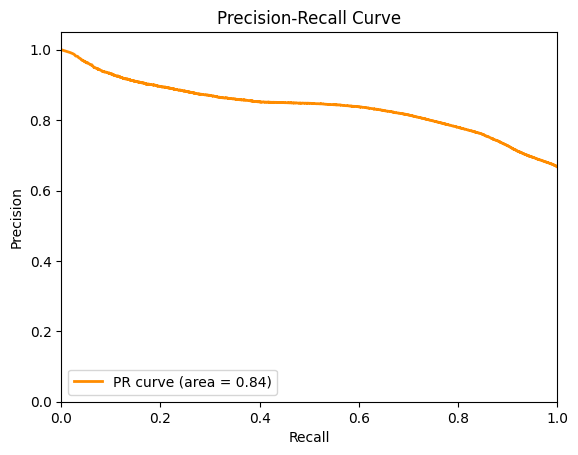

In [ ]:
# Predictions: Generate predictions using the trained model on the test set features.

y_pred = model.predict([test_user_features_100, test_business_features_100, test_final_pd_100['user_id'], test_final_pd_100['business_id'],
                        test_final_pd_100['features_dot'], test_final_pd_100['avg_rating'], test_final_pd_100['num_of_reviews'],
                        test_final_pd_100['dot_is_zero'], test_final_pd_100['user_is_zero'], test_final_pd_100['business_is_zero']])

# True Labels: Extract true labels from the test set.
y_true = test_final_pd_100['rating_binary']

# Compute Precision, Recall, and Thresholds: Calculate precision and recall values across different threshold values.
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Compute AUC: Calculate the area under the precision-recall curve.
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve: Visualize the precision-recall curve.
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


## California Data

### 10%

In [25]:
# Load training and testing DataFrames from parquet files
train_final_pd_10 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/ca_data/final/train_final_10.parquet")
test_final_pd_10 = pd.read_parquet("drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/ca_data/final/test_final_10.parquet")

# Data Preprocessing:
oversampled_train_user_features_10, oversampled_train_business_features_10, oversampled_train_ratings_10, test_user_features_10, test_business_features_10, test_ratings_10, oversampled_train_10, test_final_pd_10 = preprocess_data(train_final_pd_10, test_final_pd_10, 60)


In [26]:
# Check proportions
check_train_test_proportions(oversampled_train_10, test_final_pd_10, oversampled_train_user_features_10, test_user_features_10, oversampled_train_business_features_10, test_business_features_10, 60)

Training set 'features_dot' == 0 ratio: 49.25%
Test set 'features_dot' == 0 ratio: 45.23%
Training set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9765349670817044
Training set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.048538484907561255
Test set 'user_features' == 0 when 'features_dot' == 0 ratio: 0.9755212484131809
Test set 'business_features' == 0 when 'features_dot' == 0 ratio: 0.048743302284704484
Training set 'user_features' all-zero vector ratio: 48.09%
Test set 'user_features' all-zero vector ratio: 44.13%
Training set 'business_features' all-zero vector ratio: 2.39%
Test set 'business_features' all-zero vector ratio: 2.20%


In [34]:
oversampled_train_10

,business,user,rating,avg_rating,num_of_reviews,business_id,user_id,rating_binary,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x808fc9ec9121984d:0xb1ab733253792062,108227806980153042174,5.0,4.205674,282,90181,1522051,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.19365238, 0.027938455, 0.05922342, 0.055146...",0.0,1,1,0
1,0x809ae509ae10da05:0xf1f161f0640e960f,115130631934735368471,4.0,4.339449,109,151873,2795919,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08390994, 0.08818052, 0.003522294, 0.016651...",0.0,1,1,0
2,0x809b1d6e03d4a065:0xef4e7d004c852e81,118335791579516994342,1.0,4.518610,403,154480,3386879,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.062742524, -0.059269726, 0.06362004, -0.070...",0.0,1,1,0
3,0x808df8f7a5c90bcd:0x74de3155a6f31fef,108808086100043377388,4.0,4.419355,31,50926,1628656,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12000935, -0.027605379, 0.16928692, 0.07066...",0.0,1,1,0
4,0x808fc084b404aaab:0x657c4e78798e2404,111204115437793165211,4.0,4.000000,18,87606,2070733,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.29747245, 0.04788089, -0.20062938, -0.03471...",0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7946825,0x80db512222e6feff:0x2c42561d7e32661e,106905348199799176505,4.0,4.486486,74,296082,1277424,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22356632, 0.043257225, 0.20960037, 0.039300...",0.0,1,1,0
7946826,0x808e33d5e09d498d:0xc55484e185ced019,101785938219755432764,1.0,3.311111,45,56564,329286,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07165252, 0.06663744, 0.15517211, 0.044454...",0.0,1,1,0
7946827,0x809527c3d549729b:0x55c481125f086d13,100939748434089412804,3.0,3.942308,52,129381,173596,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.108606, -0.15985082, -0.01881554, 0.1067563...",0.0,1,1,0
7946828,0x80c2b4f9b6ba63d9:0x7108c76b438cbdc6,101019042379546638355,2.0,4.225000,80,188756,188136,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.070931084, 0.105427116, 0.09251313, 0.03607...",0.0,1,1,0


In [36]:
test_final_pd_10

,business,user,rating,avg_rating,num_of_reviews,business_id,user_id,rating_binary,user_features,business_features,features_dot,dot_is_zero,user_is_zero,business_is_zero
0,0x4076550b64f1bff3:0x91af6dc13474ea96,107023111733325487356,5.0,5.000000,2,471,1299405,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00000,1,1,1
1,0x4076550b64f1bff3:0x91af6dc13474ea96,113341395329662139951,5.0,5.000000,2,471,2465381,1,"[0.28705296, 0.07009776, 0.05006238, -0.103037...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.00000,1,0,1
2,0x4cb41c74dc86650f:0xb342101f4f9ff626,110055942235947905393,5.0,4.164179,67,496,1858836,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07836055, -0.168124, 0.022968719, 0.1673648...",0.00000,1,1,0
3,0x4cb41c74dc86650f:0xb342101f4f9ff626,112012784291009953891,4.0,4.164179,67,496,2220093,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07836055, -0.168124, 0.022968719, 0.1673648...",0.00000,1,1,0
4,0x4cb41c74dc86650f:0xb342101f4f9ff626,102006791452405498507,4.0,4.164179,67,496,370422,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07836055, -0.168124, 0.022968719, 0.1673648...",0.00000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701801,0x87b781ec0ab42ea5:0x8c9bf0c87971a0b7,104148996130834440091,5.0,4.338028,71,409858,766878,1,"[0.24409656, 0.14224125, 0.08610698, -0.020024...","[0.11497137, -0.087083615, 0.1127703, -0.17409...",0.52914,0,0,0
701802,0x87b781ec0ab42ea5:0x8c9bf0c87971a0b7,102540512203773758155,5.0,4.338028,71,409858,469195,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.11497137, -0.087083615, 0.1127703, -0.17409...",0.00000,1,1,0
701803,0x87b781ec0ab42ea5:0x8c9bf0c87971a0b7,115923573706382496673,5.0,4.338028,71,409858,2942688,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.11497137, -0.087083615, 0.1127703, -0.17409...",0.00000,1,1,0
701804,0x89c6ce286cebefbd:0x722dbef3d3e20808,116199270817407400971,5.0,4.916667,12,410089,2993676,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.16645765, 0.13893563, -0.040603466, 0.1525...",0.00000,1,1,0


In [ ]:
## To handle the large dataset, set checkpoints for separate training sessions, and increase the batch size to enhance training efficiency.

# Define Model: Defines a neural network model architecture for recommendation system.

# Set the path and filename for model checkpoint
checkpoint_path = "model_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

# Extract maximum user and business IDs
max_user_id = int(train_final_pd_10['user_id'].max()) + 1
max_business_id = int(train_final_pd_10['business_id'].max()) + 1

# Define input layers for user and business features, IDs, dot product, average rating, number of reviews, and zero indicators
user_features = Input(shape=(rank,), name='user_features')
business_features = Input(shape=(rank,), name='business_features')
user_id_input = Input(shape=(1,), name='user_id')
business_id_input = Input(shape=(1,), name='business_id')
features_dot = Input(shape=(1,), name='features_dot')
avg_rating = Input(shape=(1,), name='avg_rating')
num_of_reviews = Input(shape=(1,), name='num_of_reviews')
dot_zero_input = Input(shape=(1,), name='dot_zero_input')
user_zero_input = Input(shape=(1,), name='user_zero_input')
business_zero_input = Input(shape=(1,), name='business_zero_input')

# Embed user and business IDs
user_embedding = Embedding(output_dim=32, input_dim=max_user_id, input_length=1, name='user_embedding')(user_id_input)
business_embedding = Embedding(output_dim=32, input_dim=max_business_id, input_length=1, name='business_embedding')(business_id_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)
business_vec = Flatten(name='FlattenItems')(business_embedding)

# Add dense layers for user and business features
user_fc = Dense(32, activation='relu')(user_features)
business_fc = Dense(32, activation='relu')(business_features)

# Concatenate all input features
concatenated = Concatenate()([user_fc, business_fc, user_vec, business_vec, features_dot, avg_rating, num_of_reviews, dot_zero_input, user_zero_input, business_zero_input])

# Define dense layers for the neural network
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model
model = Model(inputs=[user_features, business_features, user_id_input, business_id_input, features_dot, avg_rating, num_of_reviews, dot_zero_input, user_zero_input, business_zero_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the Model: Trains the neural network model using oversampled training data and evaluates on validation set.
model.fit([oversampled_train_user_features_10, oversampled_train_business_features_10, oversampled_train['user_id'], oversampled_train['business_id'],
           oversampled_train['features_dot'], oversampled_train['avg_rating'], oversampled_train['num_of_reviews'], oversampled_train['dot_is_zero'],
           oversampled_train['user_is_zero'], oversampled_train['business_is_zero']],
          oversampled_train['rating_binary'], batch_size=256, epochs=5, validation_split=0.1, callbacks=[checkpoint])

# Evaluate the Model on the Test Set: Evaluates the trained model on the test set and prints the metrics.
test_metrics = model.evaluate([test_user_features_10, test_business_features_10, test_final_pd_10['user_id'], test_final_pd_10['business_id'],
                test_final_pd_10['features_dot'], test_final_pd_10['avg_rating'], test_final_pd_10['num_of_reviews'],
                test_final_pd_10['dot_is_zero'], test_final_pd_10['user_is_zero'], test_final_pd_10['business_is_zero']],
                test_final_pd_10['rating_binary'])

print("Test Metrics:")
print(f"Accuracy: {test_metrics[1]}")
print(f"Precision: {test_metrics[2]}")
print(f"Recall: {test_metrics[3]}")


Epoch 1/5
27939/27939 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.7966 - precision: 0.8817 - recall: 0.6851

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27939/27939 [==============================] - 862s 31ms/step - loss: 0.4425 - accuracy: 0.7966 - precision: 0.8817 - recall: 0.6851 - val_loss: 0.2639 - val_accuracy: 0.8662 - val_precision: 0.9533 - val_recall: 0.7699
Epoch 2/5
27939/27939 [==============================] - 857s 31ms/step - loss: 0.2227 - accuracy: 0.8981 - precision: 0.9192 - recall: 0.8731 - val_loss: 0.2216 - val_accuracy: 0.8933 - val_precision: 0.9219 - val_recall: 0.8593
Epoch 3/5
27939/27939 [==============================] - 853s 31ms/step - loss: 0.1510 - accuracy: 0.9432 - precision: 0.9500 - recall: 0.9356 - val_loss: 0.2128 - val_accuracy: 0.9066 - val_precision: 0.9160 - val_recall: 0.8952
Epoch 4/5
27939/27939 [==============================] - 845s 30ms/step - loss: 0.1139 - accuracy: 0.9620 - precision: 0.9683 - recall: 0.9553 - val_loss: 0.2092 - val_accuracy: 0.9113 - val_precision: 0.9130 - val_recall: 0.9091
Epoch 5/5
21932/21932 [==============================] - 61s 3ms/step - loss: 3.5221 - acc

In [ ]:
!cp model_checkpoint.h5 'drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/ca_data/final/'
model.save('drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/ca_data/final/ca_model_10.h5')  # Saves to an HDF5 file



In [ ]:
# Continue Training the Model: Continues training the neural network model for an additional 5 epochs using the oversampled training data and evaluates on validation set.
model.fit([oversampled_train_user_features_10, oversampled_train_business_features_10, oversampled_train['user_id'], oversampled_train['business_id'],
           oversampled_train['features_dot'], oversampled_train['avg_rating'], oversampled_train['num_of_reviews'], oversampled_train['dot_is_zero'],
           oversampled_train['user_is_zero'], oversampled_train['business_is_zero']],
          oversampled_train['rating_binary'], batch_size=256, epochs=5, validation_split=0.1, callbacks=[checkpoint])


Epoch 1/5
27939/27939 [==============================] - 846s 30ms/step - loss: 0.0828 - accuracy: 0.9748 - precision: 0.9816 - recall: 0.9676 - val_loss: 0.2148 - val_accuracy: 0.9152 - val_precision: 0.9287 - val_recall: 0.8993
Epoch 2/5
27939/27939 [==============================] - 844s 30ms/step - loss: 0.0742 - accuracy: 0.9777 - precision: 0.9845 - recall: 0.9708 - val_loss: 0.2182 - val_accuracy: 0.9137 - val_precision: 0.9335 - val_recall: 0.8907
Epoch 3/5
27939/27939 [==============================] - 849s 30ms/step - loss: 0.0676 - accuracy: 0.9800 - precision: 0.9867 - recall: 0.9730 - val_loss: 0.2189 - val_accuracy: 0.9159 - val_precision: 0.9323 - val_recall: 0.8968
Epoch 4/5
27939/27939 [==============================] - 843s 30ms/step - loss: 0.0622 - accuracy: 0.9817 - precision: 0.9885 - recall: 0.9748 - val_loss: 0.2238 - val_accuracy: 0.9166 - val_precision: 0.9302 - val_recall: 0.9008
Epoch 5/5
27939/27939 [==============================] - 846s 30ms/step - loss: 

In [ ]:
model.save('drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/ca_data/final/ca_model_10_epoch10.h5')  # Saves to an HDF5 file
!cp model_checkpoint.h5 'drive/MyDrive/lse/Course Materials/ST446 Distribued Computing/project/ca_data/final/'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
